Last time on the blog, we were looking at the paper "<b style="color:#EB1960">A living biobank of ovarian cancer ex vivo models reveals profound mitotic heterogeneity</b>" [@ovarian-cancer-living-biobank].  We'll pick up where we left off, this time trying to recreate <b style="color:#EB1960">Figure 5</b>.

![<b style="color:#EB1960">Figure 5</b>.  Not my own work](./images/ovarian-fig5.png)

<details>
    <summary><b class="setups">Recap</b><b style="color:#C0CF96">: Loading the Data</b></summary>

In [ ]:
file.path = './localdata/E-MTAB-8559-quantification-raw-files/'

In [ ]:
# Load in the matrix of expected raw counts
raw.counts <- Matrix::readMM(
    paste(
        file.path,
        'E-MTAB-8559.aggregated_filtered_counts.mtx',
        sep=''
    )
)


# Load in the row names (genes)
row.info <- read.table(
    paste(
        file.path,
        'E-MTAB-8559.aggregated_filtered_counts.mtx_rows',
        sep=''
    ),
    header=FALSE,
    col.names=c("Ensembl.ID", "Redundant")
)

if (all(row.info['Ensembl.ID'] != row.info['Redundant'])) {
    # I don't understand why these datasets tend to write
    # the same name twice in each row???
    print("Warning: second column is not actually redundant!")
}

# Drop duplicate column from genes
row.info <- row.info['Ensembl.ID']

# Load in the column names (single cells)
col.info <- read.table(
    paste(
        file.path,
        'E-MTAB-8559.aggregated_filtered_counts.mtx_cols',
        sep=''
    ),
    header=FALSE,
    sep='-',
    col.names=c('Sample.Info', 'Cell.Barcode')
)
col.info['Full.ID'] <- apply(
    col.info,
    1, # Rows
    function(row) {
    paste(
        row['Sample.Info'],
        row['Cell.Barcode'],
        sep='-'
    )
})

# Load in the experimental design matrix
exp.design.table <- read.table(
    './localdata/ExpDesign-E-MTAB-8559.tsv',
    header=TRUE,
    sep='\t'
)

</details>

# <b style="color:#537FBF">Filtering</b> and <b style="color:#537FBF">Normalization</b>

In [ ]:
dim(raw.counts)

[1] 23284 19880

There are 23,284 genes and 19,880 cells - which is quite a lot!  So we should probably <b style="color:#537FBF">filter</b> some things out.

> We used three measures to identify and remove the low-quality cells. Namely, the <strong style="color:#A6A440">library size</strong>; the <strong style="color:#C0CF96">number of expressed genes</strong>; and <strong style="color:#C0CF96">the proportion of reads mapped to mitochondrial genes</strong> in all four samples. Cells exhibiting a library size lower than three <b style="color:#A6A440">Median Absolute Deviations</b> (<b style="color:#A6A440">MAD</b>) were <b style="color:#537FBF">filtered</b> out. Also, cells expressing a gene count lower than three <b style="color:#A6A440">MAD</b> were filtered out. For mitochondrial read proportions, we filtered out the cells that displayed a percentage of reads mapping to mitochondrial genes greater than three <b style="color:#A6A440">MAD</b>.

<details>
    <summary><b class="false-starts">False Start</b><b style="color:#C0CF96">: Filtering</b></summary>

## <b style="color:#A6A440">Library Size</b> <b style="color:#537FBF">Filtering</b>

In [ ]:
library.sizes <- Matrix::rowSums(raw.counts > 0)

In [ ]:
library.median.size <- median(library.sizes)
median.absolute.deviation <- median(abs(library.sizes - library.median.size))
library.lower.bound <- library.median.size - 3*median.absolute.deviation
any(library.sizes < library.lower.bound)

[1] FALSE

It seems that none of the cells have a sufficiently low <b style="color:#A6A440">library size</b>.

## Gene Count <b style="color:#537FBF">Filtering</b>

In [ ]:
gene.counts <- Matrix::rowSums(raw.counts)

In [ ]:
gene.median.counts <- median(gene.counts)
median.absolute.deviation <- median(abs(gene.counts - gene.median.counts))
gene.lower.bound <- gene.median.counts - 3*median.absolute.deviation
any(gene.counts < gene.lower.bound)

[1] FALSE

It also seems that none of the cells have a sufficiently low gene count.

## Mitochondrial <b style="color:#537FBF">Filtering</b>

For this we'll use the `biomart` package.

<details>
    <summary><b class="setups">Install</b><b style="color:#C0CF96">: biomaRt</b></summary>
    
```{bash}
conda search bioconda::r-biomart
conda install bioconda::bioconductor-biomart=2.54.0 -y
```

This is the first time I've had to use the `bioconda` channel, but [their website](https://bioconda.github.io/#:~:text=The%20bioconda%20channel%20enables%20installation,is%20set%20to%20highest%20priority.) clearly shows they're built on top of `conda-forge` so I know I'm not going to get burned by channel conflicts as has happened before.  Unfortunately it doesn't work, all versions of `biomart` have dependency conflicts somewhere (so maybe I have been burned by channel conflicts...)
    
So now I will install `biocmanager` and install it the in-R way.
    
```{bash}
# Bash
conda search conda-forge::r-biocmanager
conda install conda-forge::r-biocmanager=1.30.19 -y
```
    
```{R}
# R
BiocManager::install("biomaRt")
```

</details>

In [ ]:
library("biomaRt")

In [ ]:
# Configure biomart to use human info (as opposed to other species)
mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))

gene.to.symbol.map <- getBM(
    filters="ensembl_gene_id",
    attributes=c(
        "ensembl_gene_id",
        "hgnc_symbol"
    ),
    values=row.info$Ensembl.ID,
    mart=mart
)

Annoyingly, `getBM` silently drops IDs when it can't find a matching attribute, so we loose twenty genes:

In [ ]:
length(gene.to.symbol.map$ensembl_gene_id)
length(row.info$Ensembl.ID)

[1] 23264

[1] 23284

In [ ]:
the.lost.genes <- setdiff(
    row.info$Ensembl.ID,
    gene.to.symbol.map$ensembl_gene_id
)

We'll filtered these genes out:

In [ ]:
non.missing.gene.index <- !(row.info$Ensembl.ID %in% the.lost.genes)
filtered.counts <- raw.counts[non.missing.gene.index,]
filtered.row.info <- row.info[non.missing.gene.index,]

In [ ]:
# For some reason, r is behaving really strangely with `strsplit`
# which is why this function is so strangely complicated
mito.genes.index <- sapply(
    gene.to.symbol.map$hgnc_symbol,
    function(x) {
        if (x == "") {
            return(FALSE)
        }
        split <- strsplit(x, '-')
        if (length(split) >= 1) {
            split. <- split[[1]]
            if (length(split.) > 1) {
                split. <- split.[[1]]
            }
            out <- tolower(split.) == 'mt'
            return(out)
        }
        else {
            return(FALSE)
        }
    }
)

In [ ]:
gene.to.symbol.map[mito.genes.index, ]

,ensembl_gene_id,hgnc_symbol
,<chr>,<chr>
15116,ENSG00000198695,MT-ND6
15119,ENSG00000198712,MT-CO2
15127,ENSG00000198727,MT-CYB
15146,ENSG00000198763,MT-ND2
15153,ENSG00000198786,MT-ND5
15162,ENSG00000198804,MT-CO1
15183,ENSG00000198840,MT-ND3
15203,ENSG00000198886,MT-ND4
15205,ENSG00000198888,MT-ND1


So now we have a list of all mitochondrial genes.

In [ ]:
mito.raw <- Matrix::rowSums(filtered.counts * mito.genes.index)
not.mito.raw <- Matrix::rowSums(filtered.counts * !mito.genes.index)

In [ ]:
mito.percent <- mito.raw / not.mito.raw

In [ ]:
mito.median.percent <- median(mito.percent)
median.absolute.deviation <- median(abs(mito.percent - mito.median.percent))
mito.lower.bound <- mito.median.percent - 3*median.absolute.deviation
any(mito.percent < mito.lower.bound)

[1] FALSE

But it also seems to have been filtered out.  Thus all filtering was done before we got the "raw" counts.

This makes sense as the quote referred to <strong style="color:#A6A440">reads</strong>, not <strong style="A6A440">counts</strong>, which implies this filtering was done at the level of the FASTQ files.

## <b style="color:#A6A440">Multiplets</b>

> After this <b style="color:#537FBF">filtering</b> two cells still showed an outlier distribution on the <b style="color:#A6A440">library size</b>. These two "cells" were assumed to be <b style="color:#A6A440">muliplets</b> and were excluded from further analyses.

To see the <b style="color:#A6A440">multiplets</b>, we can make a <b style="color:#A6A440">box and whisker plot</b>.

In [ ]:
library("ggplot2")

In [ ]:
sizes.to.plot <- data.frame(library.sizes)

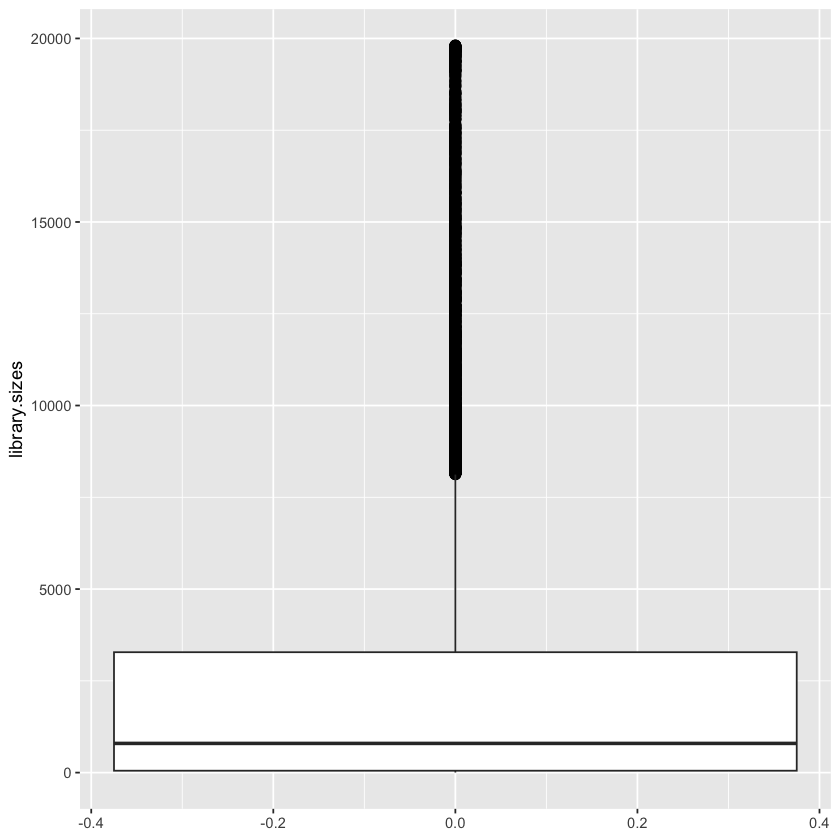

In [ ]:
ggplot(sizes.to.plot, aes(y=library.sizes)) +
geom_boxplot(outlier.colour="black", outlier.shape=16,
             outlier.size=3, notch=FALSE)

However this clearly shows more than two outliers!

</details>

::: {.column-margin}
The dataset I had was pre-filtered.
:::

## <b style="color:#537FBF">Normalization</b> and miscellaneous <b style="color:#537FBF">filtering</b>

> <b style="color:#C0CF96">Raw counts</b> of the remaining cells were then <b style="color:#537FBF">normalised</b> using the <b style="color:#537FBF">deconvolution-based method</b> and then <b style="color:#537FBF">log-transformed</b>. We also <b style="color:#537FBF">filtered out</b> the genes with average counts below 0.01 assuming these low-abundance genes to be unreliable for statistical inference.

The question is - what is this <b style="color:#537FBF">deconvolution-based method</b>?

TODO: THIS

# <b style="color:#EB1960">Figure 5a</b>

> <b style="color:#EB1960">5a)</b> <b style="color:#537FBF">t-Stochastic neighbour embedding (t-SNE)</b> plot showing <b style="color:#537FBF">clustering</b> of single cells from four <b style="color:#A6A440">OCM pairs</b>, with <b style="color:#A6A440">tumour</b> and <b style="color:#A6A440">stromal cells</b> mixed 3:1. 
>
> -- <b style="color:#C0CF96">Caption of</b> <b style="color:#EB1960">Figure 5a</b>

<details>
    <summary><b class="false-starts">False Start</b><b style="color:#C0CF96">: Which cells are <b style="color:#A6A440">tumour</b> and which cells are <b style="color:#A6A440">stromal</b>?</b></summary>

At first I thought it would be easy to tell which cells are which via hand-labeling, however we can see from below that there is no column that corresponds to cell type other `Sample.Characteristic.cell.type.`, and as we'll see it's not a very informative column.

In [ ]:
# To pretty-print `colnames`, we pasted them together with \n
# Note that we need to use `collapse`, not `sep` - I'm pretty
# sure this is because `colnames` is a vector rather than
# multiple arguments, so we need to "collapse" it.
#
# Finally, to render the \ns rather than printing "\n", we need
# to use `cat`.  All-in-all this was far more complicated
# than I thought it would be to get pretty-print working.
cat(
    paste(
        colnames(exp.design.table),
        collapse='\n'
    )
)

Assay
Sample.Characteristic.organism.
Sample.Characteristic.Ontology.Term.organism.
Sample.Characteristic.developmental.stage.
Sample.Characteristic.Ontology.Term.developmental.stage.
Sample.Characteristic.age.
Sample.Characteristic.Ontology.Term.age.
Sample.Characteristic.sex.
Sample.Characteristic.Ontology.Term.sex.
Sample.Characteristic.individual.
Sample.Characteristic.Ontology.Term.individual.
Sample.Characteristic.disease.
Sample.Characteristic.Ontology.Term.disease.
Sample.Characteristic.tumor.grading.
Sample.Characteristic.Ontology.Term.tumor.grading.
Sample.Characteristic.metastatic.site.
Sample.Characteristic.Ontology.Term.metastatic.site.
Sample.Characteristic.organism.part.
Sample.Characteristic.Ontology.Term.organism.part.
Sample.Characteristic.cell.type.
Sample.Characteristic.Ontology.Term.cell.type.
Sample.Characteristic.growth.condition.
Sample.Characteristic.Ontology.Term.growth.condition.
Factor.Value.individual.
Factor.Value.Ontology.Term.individual.

In [ ]:
unique(exp.design.table$Sample.Characteristic.cell.type.)

[1] "mix of stromal fibroblasts and epithelial tumour cells"

Thus every cell is either a <b style="color:#A6A440">stromal fibroblast</b> or an <b style="color:#A6A440">epithelial tumour cell</b>, but we're not given any indication which is which.

> <b style="color:#A6A440">Tumour</b> and <b style="color:#A6A440">stromal</b> cells from the four pairs were mixed 3:1 and analysed in parallel. <b style="color:#537FBF">tSNE plots</b> showed that the majority of cells from each sample formed distinct clusters, whereas smaller fractions formed an overlapping cluster (Fig. 5a). Based on the 3:1 mix, we reasoned that the large distinct clusters represented the <b style="color:#A6A440">tumour cells</b> while the overlapping cluster corresponded to the <b style="color:#A6A440">stromal cells</b>.

So it seems that they didn't keep track of which cells were which (which makes sense, because it'd probably be pretty hard...  Maybe they could have tagged the cells somehow, but maybe that'd be expensive or inaccurate - it's hard for me to say as I don't have the background).  Rather, they just inferred them from <b style="color:#537FBF">tSNE plots</b>.

</details>

::: {.column-margin}
Spoiler: We don't know which!
:::

So we need to run <b style="color:#537FBF">tSNE</b> - ideally, we'd like to use the exact same packages they used for analysis, but they used `scanpy`, a Python package, and this is an R notebook^[If only `sos-notebook` didn't ruin syntax highlighting...  This might require a <b class="sidequests">Sidequest</b> sometime soon.].  So, instead, we'll use the `tsne` R package.

<details>
    <summary><b class="setups">Install</b><b style="color:#C0CF96">: tsne</b></summary>
    
```{bash}
conda search conda-forge::r-tsne
conda install conda-forge::r-tsne=0.1_3.1 -y
```

</details>

In [ ]:
library(tsne)

In [ ]:
# They did PCA to reduce dims before tsne, will have to do that later
#tsne(raw.counts)

TODO: THIS